# Local Invariant Features
## Computer Vision and Image Processing - Lab Session 6 - Exercises
### Prof: Luigi Di Stefano, luigi.distefano@unibo.it
### Tutor: Pierluigi Zama Ramirez, pierluigi.zama@unibo.it - Alex Costanzino, alex.costanzino@unibo.it

### Exercise 1: Object Detection
Given a query image ('ex/bishop.jpg') detect the object in the scene images: 'scene1.jpg', 'scene2.jpg' and 'scene3.jpg'.

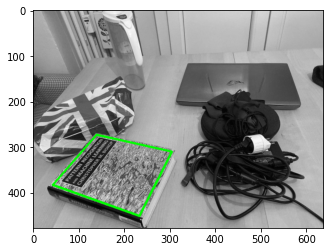

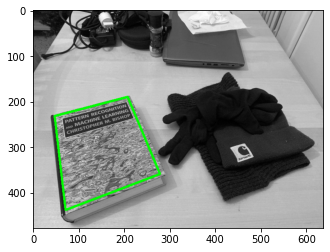

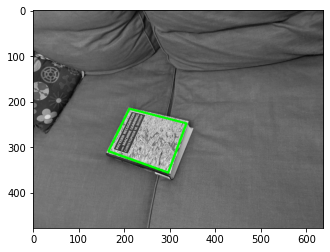

In [12]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img_query = cv2.imread('ex/bishop.jpg',0) # trainImage
img_train1 = cv2.imread('ex/scene1.jpg',0) # queryImage
img_train2 = cv2.imread('ex/scene2.jpg',0)
img_train3 = cv2.imread('ex/scene3.jpg',0)

imgs_train = (img_train1,img_train2,img_train3)

def detectObjectInImage(img_query,img_train):

    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp_query,des_query = sift.detectAndCompute(img_query,None)
    kp_train,des_train = sift.detectAndCompute(img_train,None)

    '''img=cv2.drawKeypoints(img_train,kp_train,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img)
    plt.show()

    img=cv2.drawKeypoints(img_query,kp_query,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img)
    plt.show()'''

    # Defining index for approximate kdtree algorithm
    FLANN_INDEX_KDTREE = 1

    # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

    # Defining search params.
    # checks=50 specifies the number of times the trees in the index should be recursively traversed.
    # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

    # Initializing matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Matching and finding the 2 closest elements for each query descriptor.
    matches = flann.knnMatch(des_query,des_train,k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    
    # Checking if we found enough matching
    MIN_MATCH_COUNT = 10
    if len(good)>MIN_MATCH_COUNT:
        # building the corrspondences arrays of good matches
        src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        # Using RANSAC to estimate a robust homography. 
        # It returns the homography M and a mask for the discarded points
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        # Mask of discarded point used in visualization
        matchesMask = mask.ravel().tolist()
        
        # Corners of the query image
        h,w = img_query.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        
        # Projecting the corners into the train image
        dst = cv2.perspectiveTransform(pts,M)
        
        # Drawing the bounding box
        img_train = cv2.cvtColor(img_train,cv2.COLOR_GRAY2BGR)
        img_train = cv2.polylines(img_train,[np.int32(dst)],True,(0,255,0),3, cv2.LINE_8)

        plt.imshow(cv2.cvtColor(img_train,cv2.COLOR_BGR2RGB))
        plt.show()

    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None  


for img_train in imgs_train :
    detectObjectInImage(img_query,img_train)

### Exercise 2: Image Search
Given a query image ('ex/bishop.jpg') and several train images ('ex/scene1.jpg', 'ex/scene2.jpg', 'ex/scene3.jpg', 'ex/scene4.jpg', 'ex/scene5.jpg') implement an image search algorithm to find which images contain the query object.

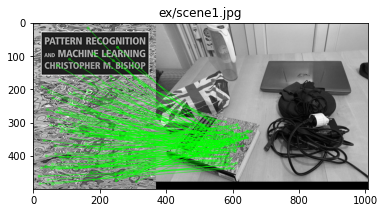

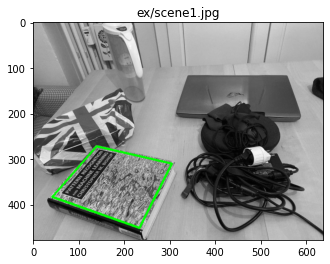

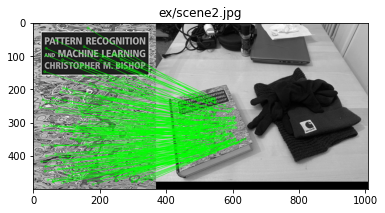

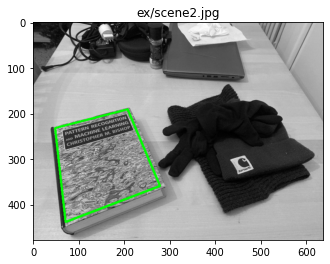

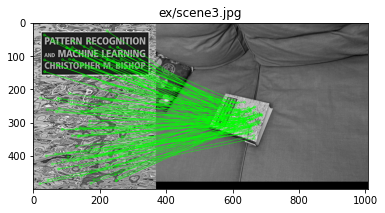

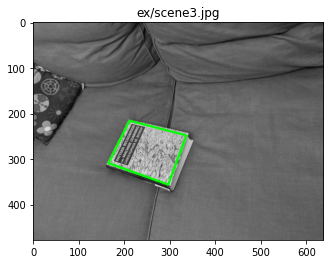

Not enough matches are found - 19/50
Not enough matches are found - 10/50
Object found in train imgs  ['ex/scene1.jpg', 'ex/scene2.jpg', 'ex/scene3.jpg']


In [28]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

imgs_train = ('ex/scene1.jpg','ex/scene2.jpg','ex/scene3.jpg','ex/scene4.jpg','ex/scene5.jpg')

def detectObjectInImage(img_query_name,img_train_name,min_match_count):

    img_query = cv2.imread(img_query_name,0)
    img_train = cv2.imread(img_train_name,0) 

    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp_query,des_query = sift.detectAndCompute(img_query,None)
    kp_train,des_train = sift.detectAndCompute(img_train,None)

    '''img=cv2.drawKeypoints(img_train,kp_train,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img)
    plt.show()

    img=cv2.drawKeypoints(img_query,kp_query,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img)
    plt.show()'''

    # Defining index for approximate kdtree algorithm
    FLANN_INDEX_KDTREE = 1

    # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

    # Defining search params.
    # checks=50 specifies the number of times the trees in the index should be recursively traversed.
    # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

    # Initializing matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Matching and finding the 2 closest elements for each query descriptor.
    matches = flann.knnMatch(des_query,des_train,k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    
    # Checking if we found enough matching
    if len(good)>min_match_count:
        # building the corrspondences arrays of good matches
        src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        # Using RANSAC to estimate a robust homography. 
        # It returns the homography M and a mask for the discarded points
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        # Mask of discarded point used in visualization
        matchesMask = mask.ravel().tolist()

        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None, # not draw keypoints only matching lines
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2) # not draw keypoints only lines
        img3 = cv2.drawMatches(img_query,kp_query,img_train,kp_train,good,None,**draw_params)
        plt.title(img_train_name)
        plt.imshow(img3, 'gray')
        plt.show()
        
        # Corners of the query image
        h,w = img_query.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        
        # Projecting the corners into the train image
        dst = cv2.perspectiveTransform(pts,M)
        
        # Drawing the bounding box
        img_train = cv2.cvtColor(img_train,cv2.COLOR_GRAY2BGR)
        img_train = cv2.polylines(img_train,[np.int32(dst)],True,(0,255,0),3, cv2.LINE_8)
        return True,img_train

    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None
        return False,None  

train_imgs_ok = []
MIN_MATCH_COUNT = 50
for img_train in imgs_train :
    res,img_train_res = detectObjectInImage('ex/bishop.jpg',img_train,MIN_MATCH_COUNT)
    if res :
        train_imgs_ok.append(img_train)
        plt.title(img_train)
        plt.imshow(cv2.cvtColor(img_train_res,cv2.COLOR_BGR2RGB))
        plt.show()

print('Object found in train imgs ',train_imgs_ok)


### Exercise 3: Mosaicing (aka Panorama Stitching)
Given two images stitch them in a single image. 

Test it on 'ex/panorama_left_rgb.jpg' and 'ex/panorama_right_rgb.jpg' or 'ex/panorama_left.jpg' and 'ex/panorama_right.jpg'.

_Tips:_ 
* Find correspondences between the two images
* Find an homography
* Warp one image and restore values for the other image 

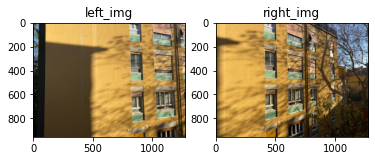

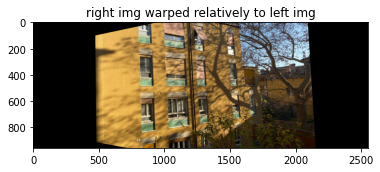

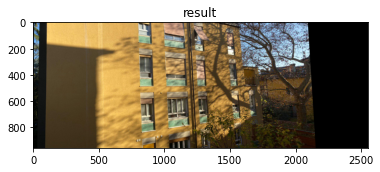

In [73]:
# Write your solution here
MIN_MATCH_COUNT = 50

right_img = cv2.imread('ex/panorama_right_rgb.jpg')
left_img = cv2.imread('ex/panorama_left_rgb.jpg')

plt.subplot(1,2,1)
plt.title('left_img')
plt.imshow(cv2.cvtColor(left_img,cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.title('right_img')
plt.imshow(cv2.cvtColor(right_img,cv2.COLOR_BGR2RGB))
plt.show()

sift = cv2.SIFT_create()

kp_left,des_left = sift.detectAndCompute(left_img,None)
kp_right,des_right = sift.detectAndCompute(right_img,None)
    
# FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des_left,des_right,k=2)
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp_left[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_right[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    # Using RANSAC to estimate a robust homography. 
    M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                singlePointColor = None, # not draw keypoints only matching lines
                matchesMask = matchesMask, # draw only inliers
                flags = 2) # not draw keypoints only lines
    '''img3 = cv2.drawMatches(left_img,kp_left,right_img,kp_right,good,None,**draw_params)
    plt.imshow(img3, 'gray')
    plt.show()'''

    # faccio il warping dell'immagine destra rispetto all'immagine sinistra
    warped = cv2.warpPerspective(right_img, M, (right_img.shape[1]+left_img.shape[1],left_img.shape[0]))
    plt.title('right img warped relatively to left img')
    plt.imshow(cv2.cvtColor(warped,cv2.COLOR_BGR2RGB))
    plt.show()

    # sostituisco nell'immagine i pixel appartenenti all'immagine sx con i relativi valori
    warped[0:left_img.shape[0],0:left_img.shape[1]] = left_img
    plt.title('result')
    plt.imshow(cv2.cvtColor(warped,cv2.COLOR_BGR2RGB))
    plt.show()





### Exercise 4: Augmentated Reality 
Given an image ('ex/stregatto.jpg') implement an augmented reality algorithm to project the image into the surface of the query object ('ex/bishop.jpg).

Moreover, restore the values of the original scene image instead of black pixels obtained with warping. 

Test it on scene images 'ex/scene1.jpg', 'ex/scene2.jpg', 'ex/scene3.jpg'.

_Expected Results_:

<img src="LabSession6Images/ar_ex.png" width="400">

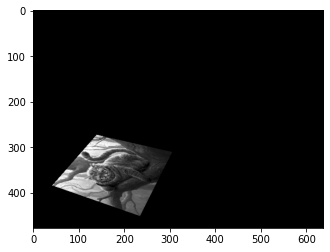

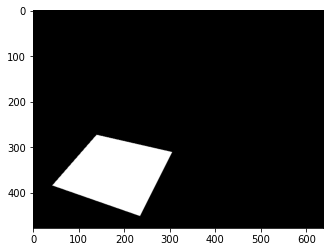

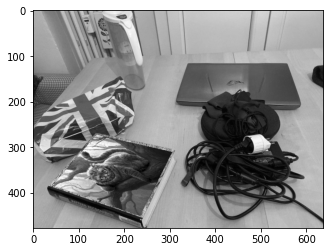

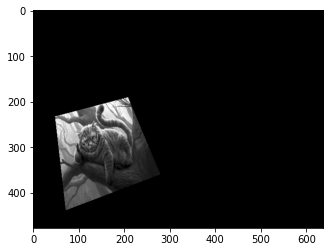

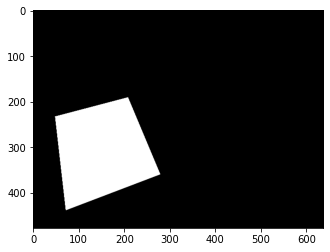

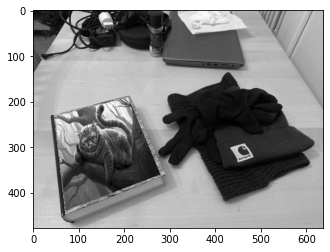

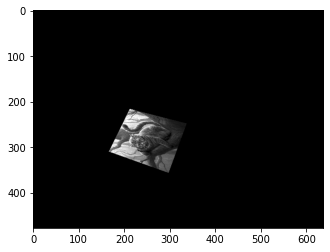

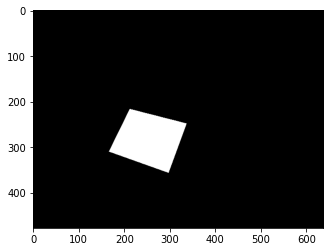

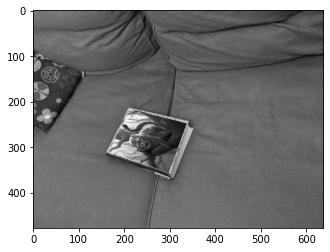

In [25]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# 1. Trovare libro nella scena 
# 2. Trovare l'omografia
# 3. Warp dello stregatto nella scena
# 4. Sostituire i pixels neri con quelli della scena

img_query = cv2.imread('ex/bishop.jpg',0) # trainImage
img_train1 = cv2.imread('ex/scene1.jpg',0) # queryImage
img_train2 = cv2.imread('ex/scene2.jpg',0)
img_train3 = cv2.imread('ex/scene3.jpg',0)
cat = cv2.imread('ex/stregatto.jpg',0)

imgs_train = (img_train1,img_train2,img_train3)

def ProjectImgInScene(img_query,img_train,img2project):

    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp_query,des_query = sift.detectAndCompute(img_query,None)
    kp_train,des_train = sift.detectAndCompute(img_train,None)

    '''img=cv2.drawKeypoints(img_train,kp_train,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img)
    plt.show()

    img=cv2.drawKeypoints(img_query,kp_query,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img)
    plt.show()'''

    # Defining index for approximate kdtree algorithm
    FLANN_INDEX_KDTREE = 1

    # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

    # Defining search params.
    # checks=50 specifies the number of times the trees in the index should be recursively traversed.
    # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

    # Initializing matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Matching and finding the 2 closest elements for each query descriptor.
    matches = flann.knnMatch(des_query,des_train,k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    
    # Checking if we found enough matching
    MIN_MATCH_COUNT = 50
    if len(good)>MIN_MATCH_COUNT:
        # building the corrspondences arrays of good matches
        src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        # Using RANSAC to estimate a robust homography. 
        # It returns the homography M and a mask for the discarded points
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        '''
        # Se vogliamo disegnare le corrispondenze
        # Mask of discarded point used in visualization
        matchesMask = mask.ravel().tolist()
        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                singlePointColor = None, # not draw keypoints only matching lines
                matchesMask = matchesMask, # draw only inliers
                flags = 2) # not draw keypoints only lines
        img3 = cv2.drawMatches(left_img,kp_left,right_img,kp_right,good,None,**draw_params)
        plt.imshow(img3, 'gray')
        plt.show()'''

        
        # Corners of the query image
        h_query,w_query = img_query.shape
        pts = np.float32([ [0,0],[0,h_query-1],[w_query-1,h_query-1],[w_query-1,0] ]).reshape(-1,1,2)
        
        # Projecting the corners of the query img into the train image
        dst = cv2.perspectiveTransform(pts,M)

        # Corners of the image to project
        h_i2p, w_i2p = img2project.shape

        '''p1_i2p = [0,0]
        p2_i2p = [0,h_i2p-1]
        p3_i2p = [w_i2p-1,h_i2p-1]
        p4_i2p = [w_i2p-1,0]
        pts_i2p = np.array([p1_i2p,p2_i2p,p3_i2p,p4_i2p],dtype=np.float32)'''
        pts_i2p = np.float32([ [0,0],[0,h_i2p-1],[w_i2p-1,h_i2p-1],[w_i2p-1,0] ]).reshape(-1,1,2)

        # Get perspective transformation (between the points of the query img projected into the train image
        # and the points of the img to project)
        pt = cv2.getPerspectiveTransform(pts_i2p,dst)

        # Warp img to project
        warped = cv2.warpPerspective(cat, pt, (img_train.shape[1],img_train.shape[0]))
        plt.imshow(cv2.cvtColor(warped,cv2.COLOR_BGR2RGB))
        plt.show()

        # White Mask to understand which are black pixels introduced by warping
        white_mask = np.ones([h_i2p,w_i2p],dtype=np.uint8)*255
        warped_white_mask = cv2.warpPerspective(white_mask,pt,(img_train.shape[1],img_train.shape[0]))

        plt.imshow(cv2.cvtColor(warped_white_mask,cv2.COLOR_BGR2RGB))
        plt.show()

        # La cornice è rappresentata dai punti neri (0)
        cornice = np.equal(warped_white_mask,0)
        
        # Sostituisco i punti corrispondenti alla cornice con i valori originali
        warped[cornice]=img_train[cornice]

        plt.imshow(cv2.cvtColor(warped,cv2.COLOR_BGR2RGB))
        plt.show()

    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None  


for img_train in imgs_train :
    ProjectImgInScene(img_query,img_train,cat)